Saving training.csv to training (3).csv

 Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23719 entries, 0 to 23718
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               23719 non-null  object 
 1   home_team          23719 non-null  object 
 2   away_team          23719 non-null  object 
 3   home_score         23719 non-null  int64  
 4   away_score         23719 non-null  int64  
 5   home_team_victory  23719 non-null  bool   
 6   draw               23719 non-null  bool   
 7   tournament_name    23719 non-null  object 
 8   city               23719 non-null  object 
 9   country            23719 non-null  object 
 10  neutral            23719 non-null  bool   
 11  scoring_team       22696 non-null  object 
 12  scoring_player     22696 non-null  object 
 13  minute             22592 non-null  float64
 14  own_goal           22696 non-null  object 
 15  penalty  

<ipython-input-4-3535a30136f7>:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])  # Mode for categorical
<ipython-input-4-3535a30136f7>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=df["goal_diff"], palette="coolwarm")



 Feature Engineering Completed.

 Model Performance Metrics:
✔ Test Set Accuracy: 0.5409
✔ ROC AUC Score: 0.4597
✔ Confusion Matrix:
 [[ 160 1893]
 [ 285 2406]]


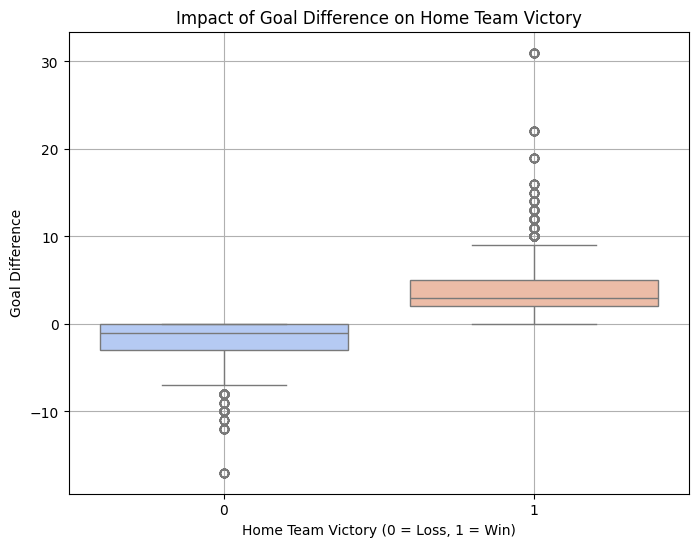

In [4]:
#  Google Colab: Upload Local Files
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

#  Upload dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

#  Display dataset info
print("\n Dataset Overview:\n")
print(df.info())  # Show data types & missing values
print("\n First few rows of the dataset:\n")
print(df.head())

# ---  DATA CLEANING ---
#  Convert 'date' column to datetime format (if exists)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

#  Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

#  Fill missing values: Numeric with mean, Categorical with mode
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].fillna(df[col].mode()[0])  # Mode for categorical
    else:
        df[col] = df[col].fillna(df[col].mean())  # Mean for numeric

#  Ensure 'home_team_victory' is binary (0 or 1)
df["home_team_victory"] = df["home_team_victory"].astype(int)

print("\n Data cleaning completed.")

# ---  FEATURE ENGINEERING ---
df["goal_diff"] = df["home_score"] - df["away_score"]  # Goal difference feature
df["score_interaction"] = df["home_score"] * df["away_score"]  # Interaction term

#  Convert categorical variables to numeric using Label Encoding
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print("\n Feature Engineering Completed.")

# ---  MODEL TRAINING (LOGISTIC REGRESSION) ---
#  Define features (X) and target (y)
X = df.drop(columns=["home_team_victory"])  # Features
y = df["home_team_victory"]  # Target variable

#  Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

#  Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#  Train Logistic Regression Model (FASTER METHOD)
logit_model = LogisticRegression(solver='liblinear', max_iter=300, penalty='l2')
logit_model.fit(X_train, y_train)

#  Predict on Test Set
y_pred_class = logit_model.predict(X_test)
y_pred_prob = logit_model.predict_proba(X_test)[:, 1]  # Get probability scores

# ---  MODEL EVALUATION ---
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_class)

print("\n Model Performance Metrics:")
print(f"✔ Test Set Accuracy: {accuracy:.4f}")
print(f"✔ ROC AUC Score: {roc_auc:.4f}")
print("✔ Confusion Matrix:\n", conf_matrix)

# ---  VISUALIZATION ---
plt.figure(figsize=(8, 6))
sns.boxplot(x=y, y=df["goal_diff"], palette="coolwarm")
plt.xlabel("Home Team Victory (0 = Loss, 1 = Win)")
plt.ylabel("Goal Difference")
plt.title("Impact of Goal Difference on Home Team Victory")
plt.grid(True)
plt.show()